# Sentiment Analysis(감정분석)
영화 리뷰 글을 TorchText를 사용해서   
긍정, 부정 평가를 다루는 모델을 만들어 본다


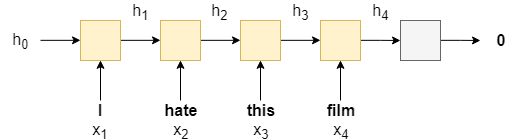

-사전 라이브러리 설치 필요  
-TorchText 설치하기  
    pip install torchtext

In [9]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

In [10]:
# Hyperparameter
num_batch = 128
num_layers = 1
hidden_size = 128
embedding_dim = 128
class_num = 2
dropout = 0.2
learning_rate = 0.01
epoch = 3

In [11]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# [1] Data

IMDB dataset  
 -영문으로 된 5만건의 영화 리뷰 텍스트 데이터 셋  
 -Label --> pos(2), neg(1) 

-TorchText의 Field 클래스는 데이터를 어떻게 처리할 것인지 정하는 객체이다.

In [12]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)


-TorchText에서 제공하는 IMDB 데이셋을 다운로드 한다

In [13]:
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

print(f'Number of training samples: {len(trainset)}')
print(f'Number of test samples: {len(testset)}')

downloading aclImdb_v1.tar.gz


.data\imdb\aclImdb_v1.tar.gz: 100%|███████████████████████████████████████████████| 84.1M/84.1M [00:37<00:00, 2.22MB/s]


KeyboardInterrupt: 

In [ ]:
#Train data, Validation data로 나누기
train_data, val_data = trainset.split(split_ratio=0.8, random_state=random.seed(1234))

#Batchfy
train_iter, val_iter, test_iter = data.BucketIterator.splits((train_data, val_data, testset), batch_size=num_batch, shuffle=True)

 (pad)와 (unk) 토큰이 추가 되어 단어장이 생성된다

In [7]:
# 단어장 생성
TEXT.build_vocab(trainset, min_freq=5)   # min_freq: 입력값만큼 반복되는 단어만 단어장 생성
LABEL.build_vocab(trainset)                                 # 나머지는 <unk> 처리
\
voca_num = len(TEXT.vocab)

print(f'Unique tokens in TEXT vocabulary: { len(TEXT.vocab)}')
print(f'Unique tokens in LABEL vocabulary: { len(LABEL.vocab) }')

Unique tokens in TEXT vocabulary: 46159
Unique tokens in LABEL vocabulary: 3


In [8]:
print(TEXT.vocab.freqs.most_common(20)) #자주 등장하는 단어와 횟수 확인

[('the', 322198), ('a', 159953), ('and', 158572), ('of', 144462), ('to', 133967), ('is', 104171), ('in', 90527), ('i', 70480), ('this', 69714), ('that', 66292), ('it', 65505), ('/><br', 50935), ('was', 47024), ('as', 45102), ('for', 42843), ('with', 42729), ('but', 39764), ('on', 31619), ('movie', 30887), ('his', 29059)]


In [1]:
print(TEXT.vocab.stoi) # 어휘사전(dict), 키값은 voca이고 value값은 인덱스 값
                       # stoi(string to int)


In [10]:
print(LABEL.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f060821d290>>, {'<unk>': 0, 'neg': 1, 'pos': 2})




# [2] Model

In [11]:
class SeqModel(nn.Module):
    def __init__(self, n_vocab,  hidden_dim, embed_dim, n_classes, n_layers, dropout):
        super(SeqModel, self).__init__()

        self.embedding = nn.Embedding(n_vocab, embeb_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_classes)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        x = self.embedding(x)
        outputs, status = self.gru(x)
        
        outputs = outputs[:,-1,:]
        outputs = self.tanh(outputs)
        outputs = self.Linear(outputs)
        
        return outputs


In [12]:
model = SeqModel(voca_num, hidden_size, embedding_dim, class_num, num_layers, dropout).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# [3] Training

In [14]:
def evaluate(model, val_iter):
    model.eval()
    corrects = 0
    total_loss = 0
    
    for batch in val_iter:
        x_test = batch.text.to(device)
        target = batch.label.to(device)
        target.data.sub_(1)  # label value (1,2) --> (0,1)로 변환
        
        output = model(x_test)
        
        outputs_softmax = F.softmax(output, dim=1)
        loss = F.cross_entropy(output, target)
        total_loss += loss.item()
        
        pred = torch.argmax(outputs_softmax.data, dim=1)
        corrects += (pred == target.data).sum().item()
        
    length = len(val_iter.dataset)
    avg_loss = total_loss / length
    avg_accuracy = (corrects/length)*100
    return avg_loss, avg_accuracy

In [15]:
#Training
for i in range(1, epoch+1):
    model.train()
    
    for b, batch in enumerate(train_iter):

        x_train = batch.text.to(device)
        target = batch.label.to(device)
        target.data.sub_(1)  # label value (1,2) --> (0,1)로 변환
        
        optimizer.zero_grad()

        output = model(x_train)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()    

    val_loss, val_accuracy = evaluate(model, val_iter)
    print( f'Epoch:{i} , Loss:{val_loss:.4f}, Accuracy:{val_accuracy:.2f} ')
          

Epoch:1 , Loss:0.0031, Accuracy:82.60 
Epoch:2 , Loss:0.0029, Accuracy:84.04 
Epoch:3 , Loss:0.0028, Accuracy:85.70 


# [4] Test

In [16]:
test_loss, test_acc = evaluate(model, test_iter)
print(f'test_loss: {test_loss :.2f}, test_acc: {test_acc:.2f}')

test_loss: 0.00, test_acc: 83.79


[Reference[1]](https://github.com/bentrevett/pytorch-sentiment-analysis)  
[Reference[2]](https://github.com/keon/3-min-pytorch)